# <a href="https://thetahat.ru/courses/ph-ds-2024-aut">Phystech@DataScience</a>
## Семинар 8 (Часть 2)

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

In [1]:
# Bot check

# HW_ID: phds_sem8_2
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [5]:
#!pip install catboost

In [4]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.datasets import fetch_california_housing

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sns.set(font_scale=1.8, palette='Set2')

##  Сравнение различных бустингов и случайного леса

###  №1 Задача регрессии на предсказание цены квартир

Исследуем зависимость качества предсказаний градиентного бустинга и случайного леса в зависимости от числа базовых моделей на примере задаче регрессии. Для случайного леса будем использовать класс `RandomForestRegressor` библиотеки `sklearn`. В качестве таргета будет предсказание цены квартир в Калифорнии в зависимости от различных параметров.

In [6]:
housing = fetch_california_housing()
print("Признаки:",housing.feature_names)
X, y = housing.data, housing.target

Признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Разобьём данные на обучающую выборку и на тестовую, выделив на тест 25% данных.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [8]:
def plot_compare_estimators(estimator_labels, param_grid, train_metrics,
                            test_metrics, param_label='', metrics_label='',
                            title=''):
    '''Функция для построения графиков зависимости целевой метрики
    от некоторого параметра модели на обучающей и на валидационной
    выборке.

    :param estimator_labels: массив названий моделей
    :param param_grid: значения исследуемого параметра
    :param train_metrics: массив, где i-ый элемент -
        это массив значений метрики на обучающей выборке для i-ой модели
    :param test_metrics: массив, где i-ый элемент -
        это массив значений метрики на валидационной выборке для i-ой модели
    :param param_label: названия параметра
    :param metrics_label: название метрики
    :param title: заголовок для графика
    '''

    plt.figure(figsize=(20, 7))

    for estimator_id in range(len(estimator_labels)):
        label = estimator_labels[estimator_id]
        plt.plot(
            param_grid, train_metrics[estimator_id],
            label=f'{label} train', linewidth=3
        )
        plt.plot(
            param_grid, test_metrics[estimator_id],
            label=f'{label} test', linewidth=3
        )

    plt.legend()
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.title(title, fontsize=20)

#### Обучим случайный лес для разного числа деревьев и посчитаем `mse`.

In [9]:
rf_mse_train = []  # метрика на трейне
rf_mse_test = []  # метрика на тесте
n_estimators_grid = range(1, 300, 10)

for n_estimators in tqdm(n_estimators_grid):
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_mse_train.append(mse(y_train, rf.predict(X_train)))
    rf_mse_test.append(mse(y_test, rf.predict(X_test)))

  0%|          | 0/30 [00:00<?, ?it/s]

Обучим градиентный бустинг для разного числа деревьев и посчитаем `mse`.

In [10]:
boosting_mse_train = []
boosting_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    gb = GradientBoostingRegressor(n_estimators=n_estimators)
    gb.fit(X_train, y_train)
    boosting_mse_train.append(mse(y_train, gb.predict(X_train)))
    boosting_mse_test.append(mse(y_test, gb.predict(X_test)))

  0%|          | 0/30 [00:00<?, ?it/s]

Обучим СatBoost для разного числа деревьев и посчитаем `mse`.

In [11]:
catboost_mse_train = []
catboost_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    catboost = CatBoostRegressor(iterations=n_estimators, verbose=0)
    catboost.fit(X_train, y_train)
    catboost_mse_train.append(mse(y_train, catboost.predict(X_train)))
    catboost_mse_test.append(mse(y_test, catboost.predict(X_test)))

  0%|          | 0/30 [00:00<?, ?it/s]

Обучим LGBM для разного числа деревьев и посчитаем `mse`.

In [12]:
lgbm_mse_train = []
lgbm_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    lgbm = LGBMRegressor(n_estimators=n_estimators)
    lgbm.fit(X_train, y_train)
    lgbm_mse_train.append(mse(y_train, lgbm.predict(X_train)))
    lgbm_mse_test.append(mse(y_test, lgbm.predict(X_test)))

  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start training from score 2.065055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start training from score 2.065055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start traini

Построим график зависимости `mse` от количества базовых моделей.

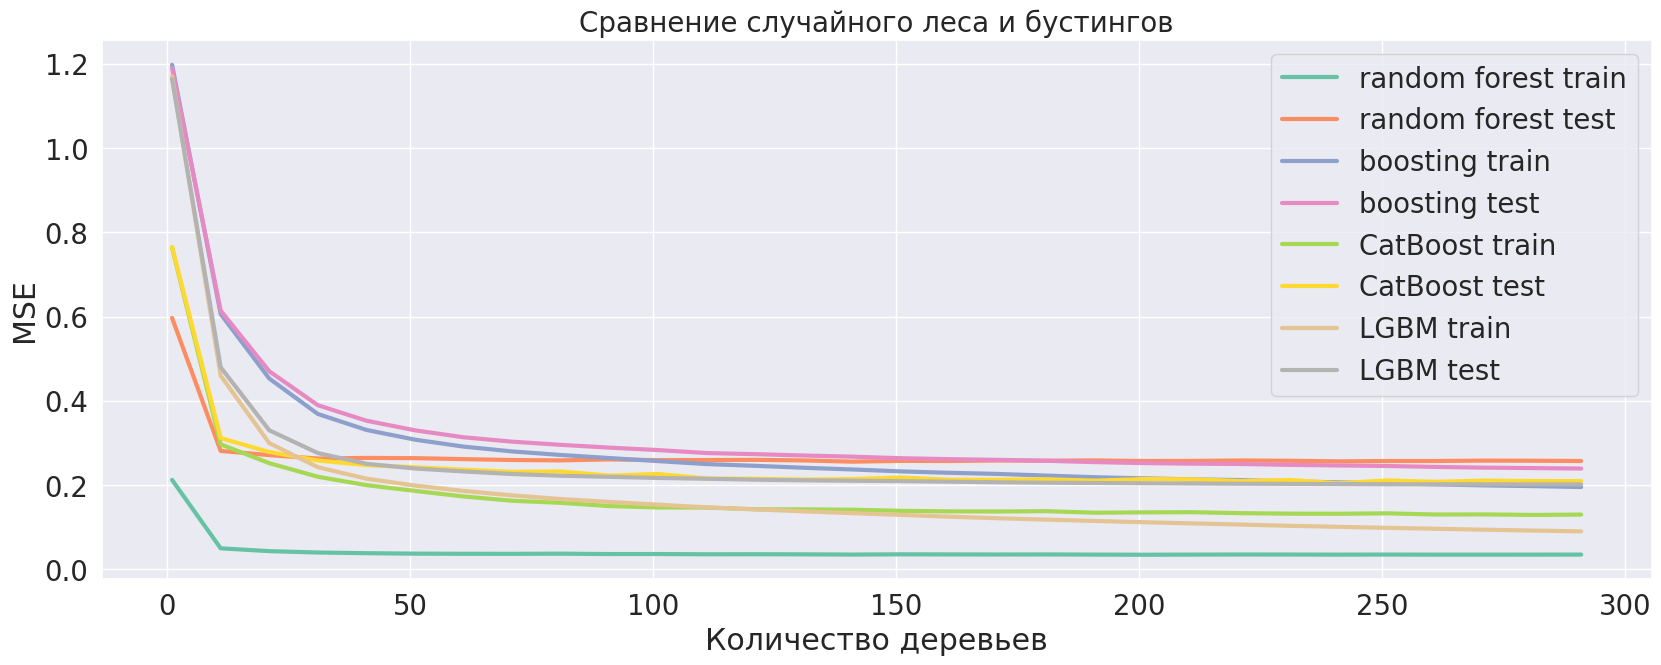

In [13]:
plot_compare_estimators(
    ['random forest', 'boosting', "CatBoost", "LGBM"], n_estimators_grid,
    [rf_mse_train, boosting_mse_train, catboost_mse_train, lgbm_mse_train],
    [rf_mse_test, boosting_mse_test, catboost_mse_test,lgbm_mse_test],
    'Количество деревьев', 'MSE',
    'Сравнение случайного леса и бустингов'
)

**Вывод:**

С увеличением числа деревьев лосс у случайного леса снижается быстрее, но быстро достигает плато. Также можно заметить, что случайный лес склонен к переобучению — его лосс на тестовых данных стабильно выше, чем на обучающих.

В случае бустинга лосс уменьшается медленнее, но значения на трейне и тесте остаются примерно одинаковыми, что указывает на отсутствие явного переобучения. К концу нашей сетки лосс для бустинга всё ещё продолжает снижаться. Однако ближе к концу и у бустинга начинают расходиться значения лосса на тренировочных и тестовых данных, что указывает на начало переобучения.

#### Сравним времена обучения и предсказания случайного леса и бустингов с параметрами по умолчанию:

Градиентный бустинг

In [14]:
%%timeit

regressor_boosting = GradientBoostingRegressor().fit(X_train, y_train)

5.47 s ± 847 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
regressor_boosting = GradientBoostingRegressor().fit(X_train, y_train)

In [16]:
%%timeit

regressor_boosting.predict(X_test)

11.6 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Случайный лес

In [17]:
%%timeit

regressor_forest = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

14.7 s ± 4.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
regressor_forest = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

In [19]:
%%timeit

regressor_forest.predict(X_test)

143 ms ± 27.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


СatBoost regressor

In [20]:
%%timeit

catboost = CatBoostRegressor(silent=True).fit(X_train, y_train)

6.62 s ± 3.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
catboost = CatBoostRegressor(silent=True).fit(X_train, y_train)

In [22]:
%%timeit

catboost.predict(X_test)

20.4 ms ± 549 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


LGBM regressor

In [23]:
%%timeit

lgbm = LGBMRegressor(silent=True).fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start training from score 2.065055
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start training from score 2.065055
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-

In [24]:
lgbm = LGBMRegressor(silent=True).fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start training from score 2.065055


In [25]:
%%timeit

lgbm.predict(X_test)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [W

**Вывод:**

Обучение бустинга занимает примерно вдвое больше времени по сравнению со случайным лесом.

Однако предсказание у бустинга проходит быстрее — примерно в 3.5 раза.

### №2 Задача на классификацию студентов

Сделаем аналогичный эксперимент с датасетом для классификации на 3 класса студентов (отчислен, закончил обучение, продолжает обучение). Целевой колонкой является `Target`.

In [26]:
students = pd.read_csv("students_dropout_succes.csv")
students.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [27]:
X = students.drop(columns = ["Target"])
y = students["Target"]

Разобьём данные на обучающую и тестовую выборки, под тестовую выделим 30%. Обязательно зафиксируйте `random_state` для воспроизводимости результатов.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Обучим случайный лес для разного числа деревьев и посчитаем метрику `f1_score`.

In [32]:
rf_f1_train = []
rf_f1_test = []
n_estimators_grid = range(1, 300, 25)

for n_estimators in tqdm(n_estimators_grid):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_f1_train.append(f1_score(y_train, rf.predict(X_train), average='weighted'))
    rf_f1_test.append(f1_score(y_test, rf.predict(X_test), average='weighted'))

  0%|          | 0/12 [00:00<?, ?it/s]

Обучим градиентный бустинг для разного числа деревьев и посчитаем метрику `f1_score`.

In [36]:
catboost_f1_train = []
catboost_f1_test = []

for n_estimators in tqdm(n_estimators_grid):
    catboost = CatBoostClassifier(n_estimators=n_estimators, silent=True)
    catboost.fit(X_train, y_train)
    catboost_f1_train.append(f1_score(y_train, catboost.predict(X_train), average='weighted'))
    catboost_f1_test.append(f1_score(y_test, catboost.predict(X_test), average='weighted'))

  0%|          | 0/12 [00:00<?, ?it/s]

Обучим LGBM для разного числа деревьев и посчитаем метрику `f1_score`.

In [37]:
lgbm_f1_train = []
lgbm_f1_test = []

for n_estimators in tqdm(n_estimators_grid):
    lgbm = LGBMClassifier(n_estimators=n_estimators)
    lgbm.fit(X_train, y_train)
    lgbm_f1_train.append(f1_score(y_train, lgbm.predict(X_train), average='weighted'))
    lgbm_f1_test.append(f1_score(y_test, lgbm.predict(X_test), average='weighted'))

  0%|          | 0/12 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 3096, number of used features: 36
[LightGBM] [Info] Start training from score -1.150314
[LightGBM] [Info] Start training from score -1.729768
[LightGBM] [Info] Start training from score -0.680948
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 3096, nu

Построим график зависимости `f1_score` от количества базовых моделей.

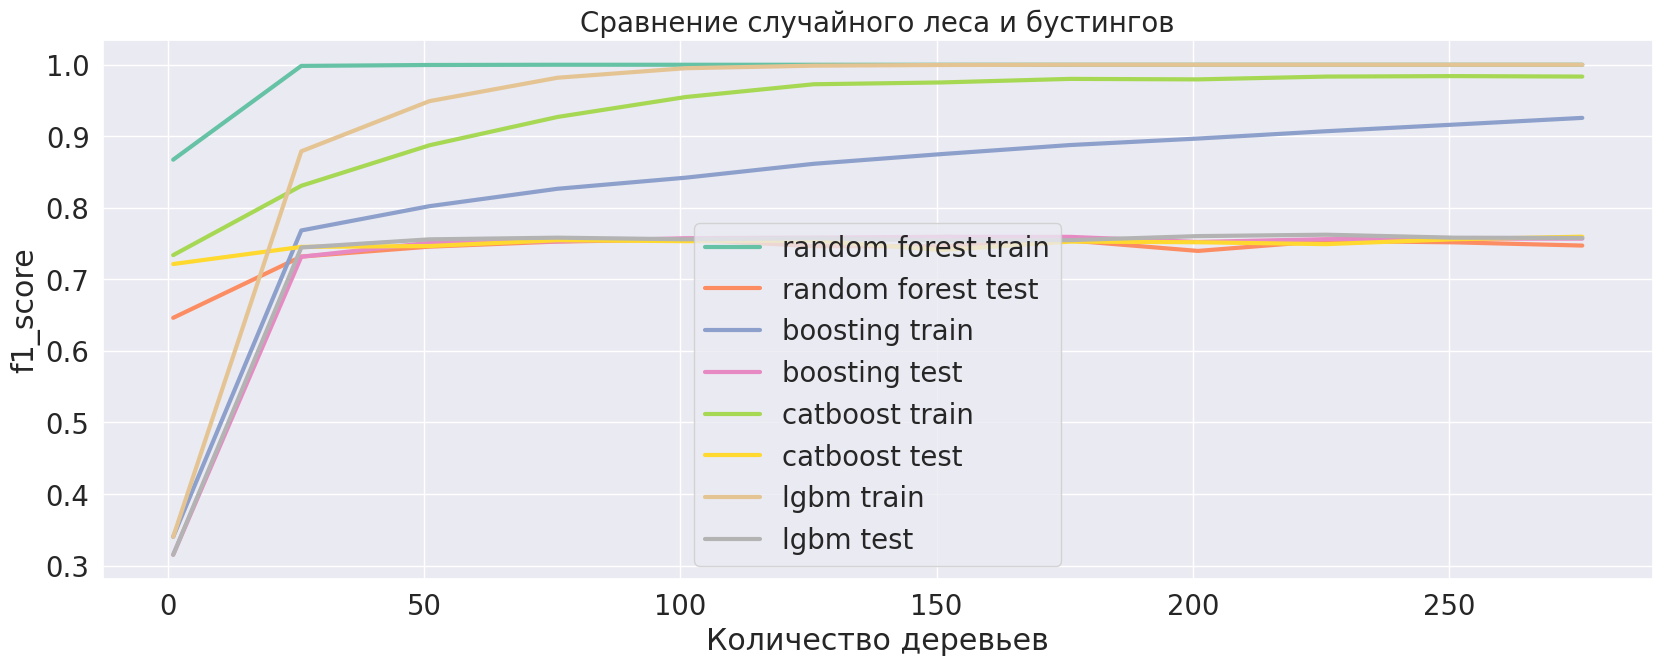

In [38]:
plot_compare_estimators(
    ['random forest', 'boosting', "catboost", "lgbm"],
    n_estimators_grid,
    [rf_f1_train, boosting_f1_train, catboost_f1_train, lgbm_f1_train],
    [rf_f1_test, boosting_f1_test, catboost_f1_test, lgbm_f1_test],
    'Количество деревьев',
    'f1_score',
    'Сравнение случайного леса и бустингов'
)

**Вывод:**

Ситуация, похоже, напоминает пункт о регрессии:

Для случайного леса точность на обучающей выборке быстро достигла значения 1, в то время как на тестовой выборке она также быстро пришла к плато, не превышающему 1, что свидетельствует о переобучении.

В случае с бустингом точность растет медленнее. Изначально результаты на тестовой и обучающей выборках почти не различаются, но после 50 деревьев наблюдается значительное расхождение. Ближе к 300 деревьям точность на обучающей выборке также достигает значения 1, а на тестовой — приближается к плато, аналогичному лесу. Тем не менее, есть вероятность, что она еще может немного вырасти.

## AutoML &mdash; LightAutoMl Framework

LAMA AutoML (Automated Machine Learning) — это система автоматизированного машинного обучения, разработанная для упрощения процесса создания и оптимизации моделей машинного обучения. Она автоматизирует следующее:

1. **Подготовка данных**. Автоматическая предобработка данных, включая нормализацию, заполнение пропущенных значений и другие преобразования.
2. **Выбор признаков**. Автоматический отбор наиболее значимых признаков для модели.
3. **Выбор модели**. Ансамблированный выбор комбинаций наилучших моделей.
4. **Настройка гиперпараметров**. Автоматическая оптимизация гиперпараметров.
5. **Оценка модели**. Автоматическая оценка производительности модели с использованием кросс-валидации и других методов.

то есть 70% процентов наших текущих задач

![image.png](attachment:image.png)

Подробнее можно прочитать тут: https://lightautoml.readthedocs.io/en/latest/pages/tutorials/Tutorial_1_basics.html

Для начала скачаем библиотеку (может занять много времени, можно попробовать ставить в Google Collab)

In [1]:
!pip install -U lightautoml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.4/416.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.7/215.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 77.8 MB/s eta 0:00:00
   ━━━

Импортируем нужные нам библиотеки

In [2]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

Для LAMA целевая колонка задается по другому, поэтому разобьем наш датасет на train и test

In [5]:
students = pd.read_csv("students_dropout_succes.csv")
train_data, test_data = train_test_split(students, test_size = 0.3, random_state=42)

Теперь зададим целевую колонку с помощью атрибута `roles`

In [6]:
roles = {
    'target': 'Target', #целевая колонка тут Target
}

#### Создание объекта Task

Сначала нам нужно создать объект `Task` — класс, чтобы указать, какую задачу должна решать модель LightAutoML с определенными потерями и метрикой, если это необходимо (более подробную информацию можно найти в документации).

Доступные типы задач

1. **'binary'** - для бинарной классификации.
2. **'reg'** - для регрессии.
3. **'multiclass'** - для многоклассовой классификации.
4. **'multi:reg'** - для множественной регрессии.
5. **'multilabel'** - для многомарковой классификации.

In [12]:
automl = TabularAutoML(
    task = Task('multiclass'), #введите, какую задачу мы собираемся решать
    timeout = 600, #введите количество времени, в течении которого будет обучаться LAMA
)

Теперь запустим обучение:

In [13]:
%%time
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

[15:49:12] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[15:49:12] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[15:49:12] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:49:12] - time: 600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 600.00 seconds


[15:49:12] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[15:49:12] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[15:49:12] Train data shape: (3096, 37)



INFO:lightautoml.reader.base:Train data shape: (3096, 37)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[15:49:22] Layer 1 train process start. Time left 589.83 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 589.83 secs


[15:49:22] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [64, 65, 66, 67, 68, 69], 'embed_sizes': array([19, 20, 16, 14, 17,  9], dtype=int32), 'data_size': 70}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.8920040384034542
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.7525997244501873
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.7043101023146193
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.6330539662042644
INFO3:lightautoml.ml_algo.torch_based.linear_model:Li

[15:49:34] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5674645763133871


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5674645763133871


[15:49:34] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[15:49:34] Time left 577.69 secs



INFO:lightautoml.automl.base:Time left 577.69 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.668751
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.592493
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.562445
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.548247
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's multi_logloss: 0.539351
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's multi_logloss: 0.535531
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's multi_logloss: 0.533457
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's multi_logloss: 0.532127
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's multi_logloss: 0.532313
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's multi_logloss: 0.532317
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[848]	valid's multi_loglos

[15:49:38] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[15:49:38] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.660901
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.587563
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.563149
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.553519
DEBUG

[15:50:21] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.5358373363632708


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.5358373363632708


[15:50:21] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[15:50:21] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-92a94ab5-65c9-43db-a571-e2b97e332ebf
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.64244
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.566018
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.549207
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.554027
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's multi_logloss: 0.569301
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[330]	valid's multi_logloss: 0.548515
INFO:optuna.study.study:Trial 0 finished with value: -0.5485146721501445 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_

[15:50:42] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -0.5485 crossentropy


[15:50:42] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 0.24810409748678125}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.579477
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[65]	valid's multi_logloss:

[15:51:10] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.5502495109104303


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.5502495109104303


[15:51:10] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[15:51:10] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0740678	test: 1.0751987	best: 1.0751987 (0)	total: 6.82ms	remaining: 20.5s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.5445361	test: 0.6063706	best: 0.6063706 (100)	total: 529ms	remaining: 15.2s
DEBUG:lightautoml.ml_algo.boost_cb:200:	lea

[15:51:30] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.5410222677203957


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.5410222677203957


[15:51:30] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[15:51:30] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 194.13 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 194.13 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-b7ae9f61-47d1-4beb-8d90-53a612245f27
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0772788	test: 1.0779157	best: 1.0779157 (0)	total: 4.33ms	remaining: 13s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.5779586	test: 0.6217480	best: 0.6217480 (100)	total: 394ms	remaining: 11.3s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 0.5315672	test: 0.5964123	best: 0.5964123 (200)	total: 750ms	remaining: 10.4s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 0.4999961	test: 0.5823304	best: 0.5823304 (300)	total: 1.13s	remaining: 10.1s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 0.4691687	test: 0.5727627	best: 0.5727627 (400)	total: 1.48s	remaining: 9.61s
DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 0.4426548	test: 0.5649063	best: 0.5647596 (494)	total: 1.87s	remaining: 

[15:54:49] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 6, 'l2_leaf_reg': 0.04298667633982508, 'min_data_in_leaf': 16}
 achieve -0.5360 crossentropy


[15:54:49] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.04298667633982508, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'min_data_in_leaf': 16, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0734480	test: 1.0742286	best: 1.0742286 (0)	total: 15.6ms	remaining: 46.7s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.5188103	test: 0.6022551	best: 0.6022551 (100)	total: 810ms	remaining: 23.3s
DEBUG:lightauto

[15:55:18] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.5399462919845872


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.5399462919845872


[15:55:18] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[15:55:18] Time left 233.63 secs



INFO:lightautoml.automl.base:Time left 233.63 secs



[15:55:18] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:55:18] Layer 2 train process start. Time left 233.60 secs


INFO:lightautoml.automl.base:Layer 2 train process start. Time left 233.60 secs


[15:55:19] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [79, 80, 81, 82, 83, 84], 'embed_sizes': array([19, 20, 16, 14, 17,  9], dtype=int32), 'data_size': 85}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.8342903450623221
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.678514169459846
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.6324293080843378
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.5735707575382021
INFO3:lightautoml.ml_algo.torch_based.linear_model:Lin

[15:55:34] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.5125516203581124


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.5125516203581124


[15:55:34] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[15:55:34] Time left 217.44 secs



INFO:lightautoml.automl.base:Time left 217.44 secs



[15:55:35] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.630306
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.568004
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.558512
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.560318
DEBUG

[15:56:06] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.5573761714410009


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.5573761714410009


[15:56:06] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[15:56:06] Time left 186.27 secs



INFO:lightautoml.automl.base:Time left 186.27 secs



[15:56:06] Layer 2 training completed.



INFO:lightautoml.automl.base:Layer 2 training completed.



[15:56:06] Blending: optimization starts with equal weights and score -0.5144562084328864


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -0.5144562084328864


[15:56:06] Blending: iteration 0: score = -0.5068400429689185, weights = [0.8175795  0.18242049]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.5068400429689185, weights = [0.8175795  0.18242049]


[15:56:06] Blending: iteration 1: score = -0.5068400429689185, weights = [0.8175795  0.18242049]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.5068400429689185, weights = [0.8175795  0.18242049]


[15:56:06] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[15:56:06] Automl preset training completed in 413.92 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 413.92 seconds



[15:56:06] Model description:
Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 0.81758 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
	 0.18242 * (5 averaged models Lvl_1_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 0.81758 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
	 0.18242 * (5 averaged models Lvl_1_Pipe_1_Mod_0_LightGBM) 



CPU times: user 10min 36s, sys: 18.3 s, total: 10min 54s
Wall time: 6min 53s


Какие модели используются в итоговом предсказании и какими весами?

**Ответ:**

В итоговом предсказании LightAutoML используются несколько базовых моделей, таких как CatBoost, LightGBM, и XGBoost. Веса моделей определяются в процессе обучения на валидационных данных и применяются в методе стекирования.  

Сделаем обратный маппинг классов (из LabelEncoding в слова)

In [14]:
mapping = automl.reader.class_mapping
def map_class(x):
    return mapping[x]
mapped = np.vectorize(map_class)

Посмотрим на результаты обучения

In [15]:
%%time

test_predictions = automl.predict(test_data)

print(f'Train F1 score: {f1_score(mapped(train_data[roles["target"]].values), np.argmax(out_of_fold_predictions.data, axis = 1), average = "weighted")}')
print(f'Test F1 score: {f1_score(mapped(test_data[roles["target"]].values), np.argmax(test_predictions.data, axis = 1), average = "weighted")}')

Train F1 score: 0.7913523402252635
Test F1 score: 0.7642501114681648
CPU times: user 3.78 s, sys: 55 ms, total: 3.84 s
Wall time: 3.59 s


Посмотрите на важность фичей:

CPU times: user 132 ms, sys: 58.8 ms, total: 191 ms
Wall time: 126 ms


<Axes: xlabel='Feature'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


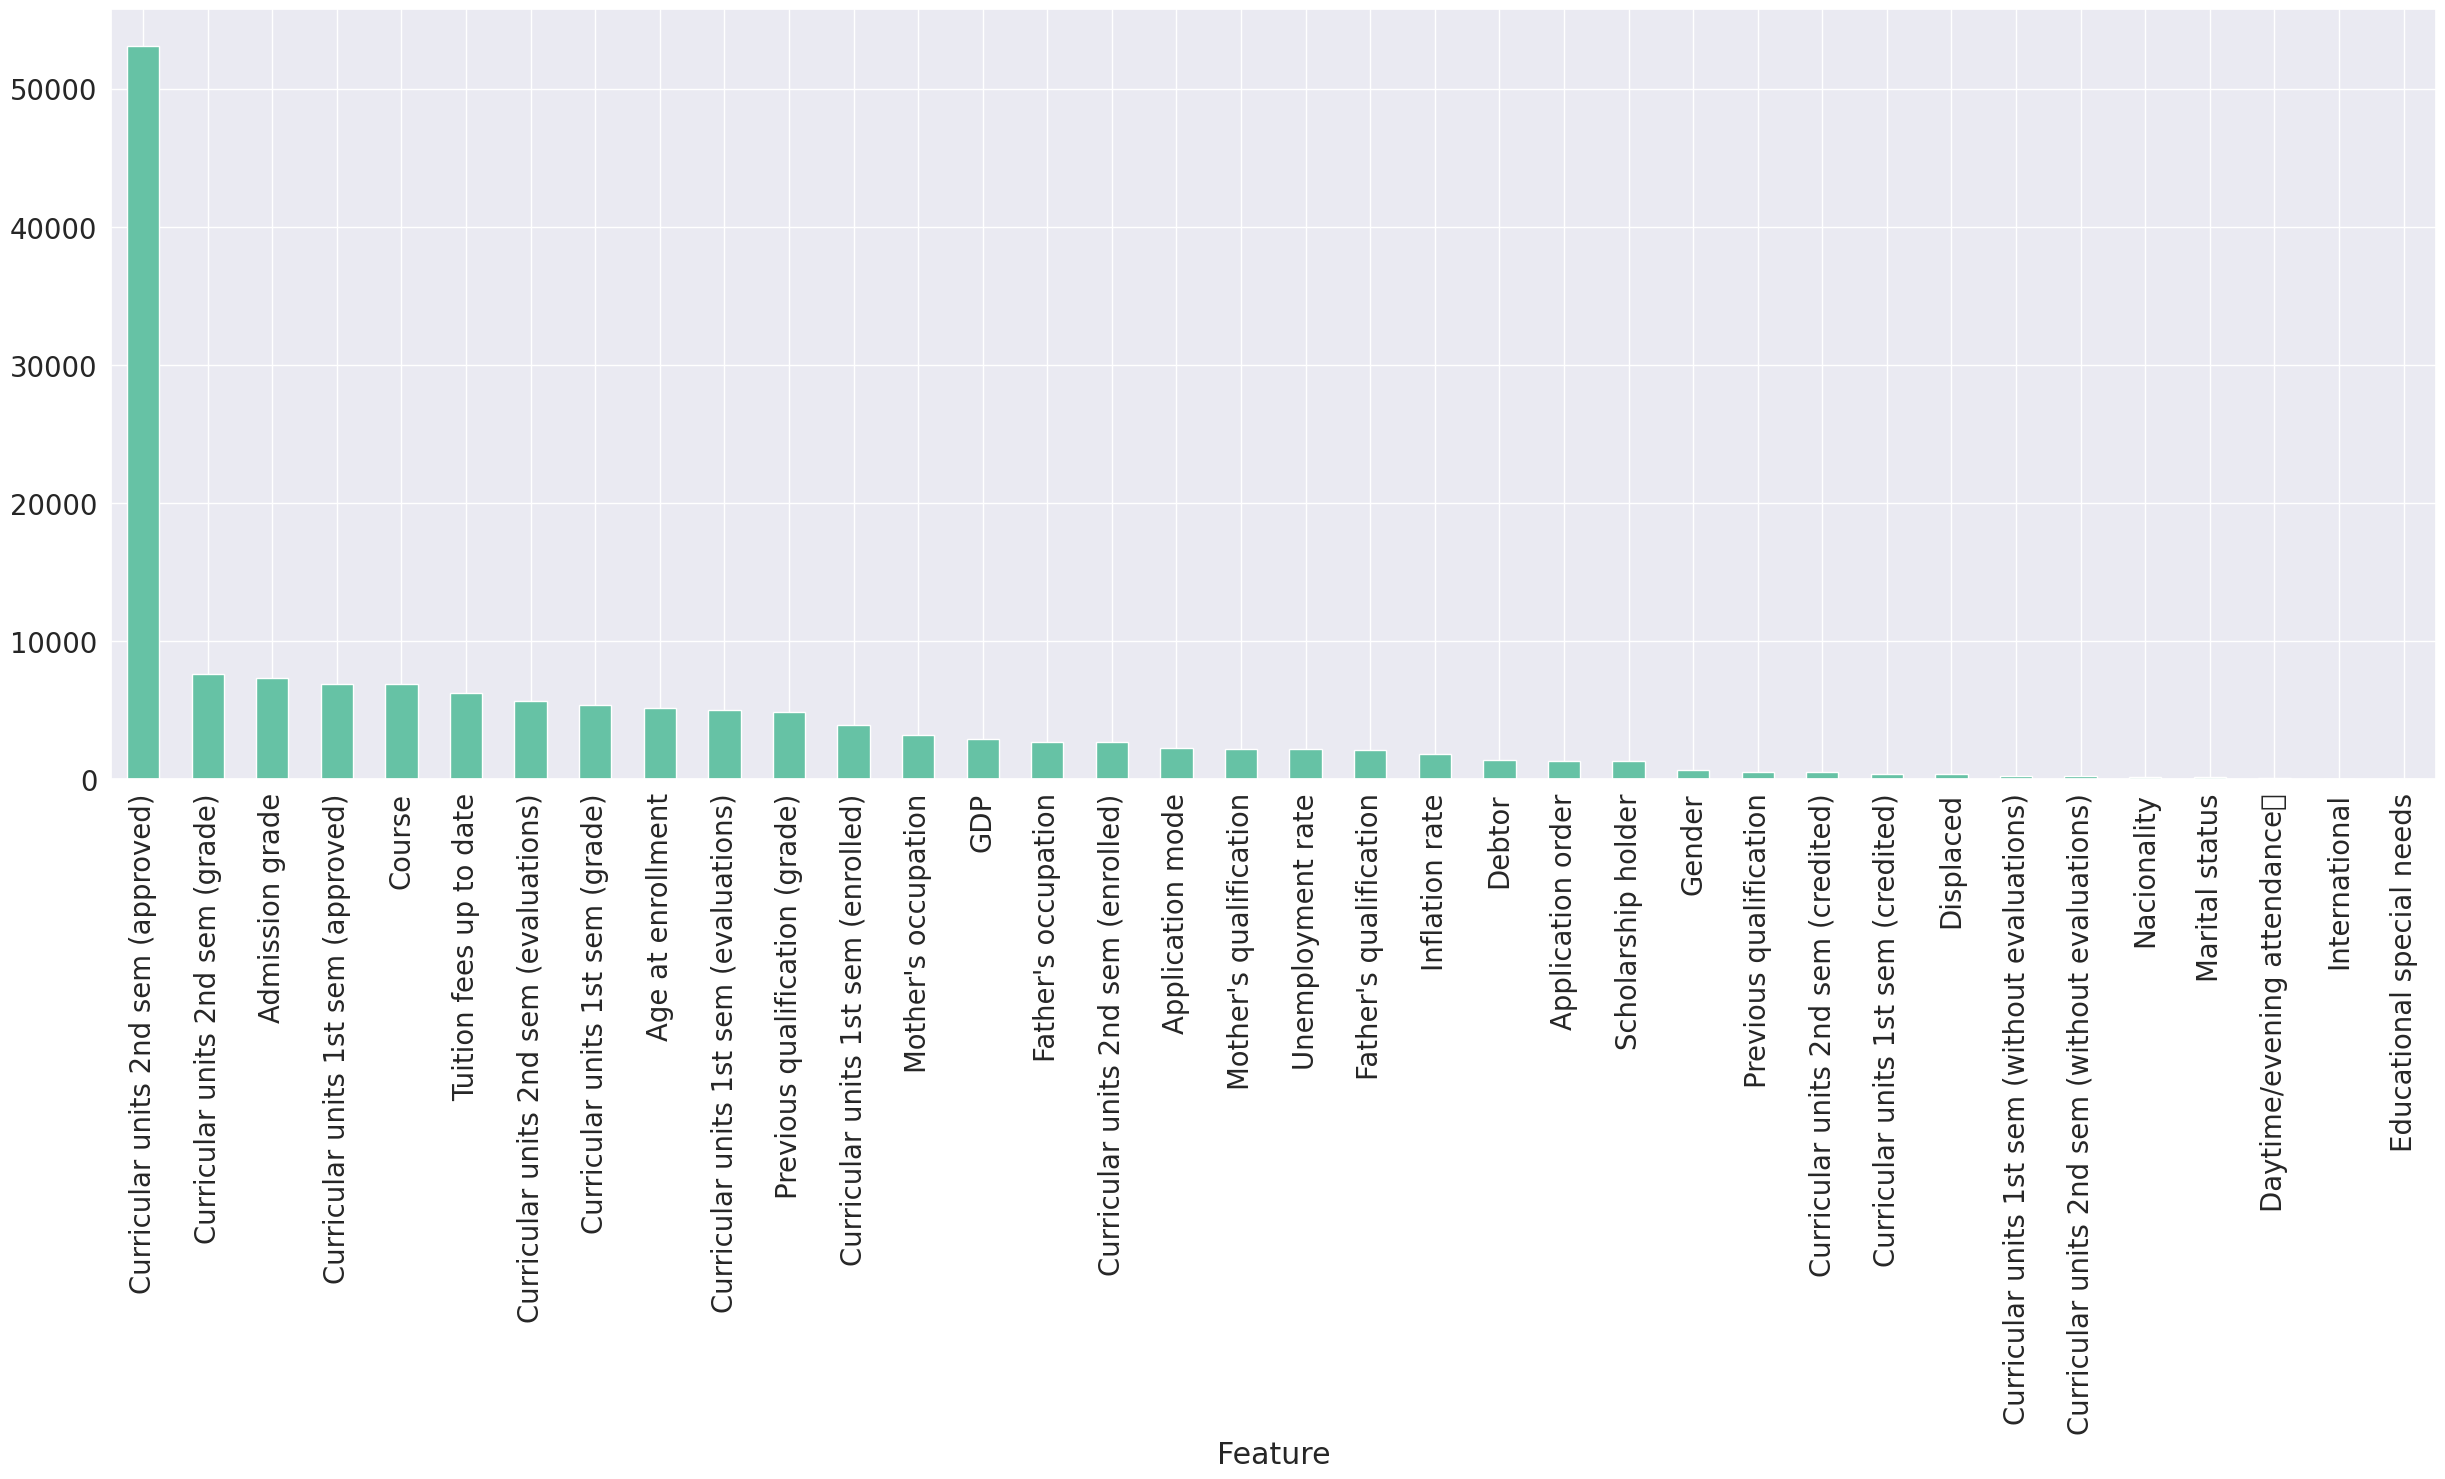

In [16]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

**Выводы:**

1. LightAutoML использует комбинацию CatBoost, LightGBM и XGBoost для улучшения точности предсказаний.

2. Итоговые предсказания формируются на основе весов, которые определяются в процессе обучения, что повышает устойчивость модели.
